In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-06-02 15:00:51.447564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = 'keypoint.csv'
model_path = 'tao_classifier.hdf5'
tf_path = 'tao_classifier.tflite'

NUM_OF_GESTURE_TAO = 10

In [5]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21*2)+1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, random_state=42)

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_GESTURE_TAO, activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_path, verbose=1, save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, verbose=1
)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
55/58 [===========================>..] - ETA: 0s - loss: 2.3570 - accuracy: 0.1136
Epoch 1: saving model to model/tao_classifier/tao_classifier.hdf5
58/58 [==============================] - 2s 10ms/step - loss: 2.3548 - accuracy: 0.1131 - val_loss: 2.2551 - val_accuracy: 0.1444
Epoch 2/1000
34/58 [================>.............] - ETA: 0s - loss: 2.2888 - accuracy: 0.1275

/Users/yychan/anaconda3/envs/mediapipe/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/58 [============================>.] - ETA: 0s - loss: 2.2843 - accuracy: 0.1287
Epoch 2: saving model to model/tao_classifier/tao_classifier.hdf5
58/58 [==============================] - 0s 6ms/step - loss: 2.2843 - accuracy: 0.1285 - val_loss: 2.2332 - val_accuracy: 0.1850
Epoch 3/1000
46/58 [======================>.......] - ETA: 0s - loss: 2.2465 - accuracy: 0.1722
Epoch 3: saving model to model/tao_classifier/tao_classifier.hdf5
58/58 [==============================] - 0s 5ms/step - loss: 2.2430 - accuracy: 0.1722 - val_loss: 2.1628 - val_accuracy: 0.3011
Epoch 4/1000
52/58 [=========================>....] - ETA: 0s - loss: 2.1966 - accuracy: 0.1991
Epoch 4: saving model to model/tao_classifier/tao_classifier.hdf5
58/58 [==============================] - 0s 5ms/step - loss: 2.1928 - accuracy: 0.2013 - val_loss: 2.0729 - val_accuracy: 0.3909
Epoch 5/1000
49/58 [========================>.....] - ETA: 0s - loss: 2.1215 - accuracy: 0.2331
Epoch 5: saving model to model/tao_classifie

In [8]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

20/20 [==============================] - 0s 1ms/step - loss: 0.1654 - accuracy: 0.9844


In [9]:
model = tf.keras.models.load_model(model_path)

In [10]:
predict_result = model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 90ms/step
[2.1839742e-05 1.9871256e-01 2.0079317e-02 1.0115390e-02 6.5510452e-01
 1.1482499e-01 5.9458870e-04 4.9530633e-04 1.4694306e-06 5.0049097e-05]
4


77/77 [==============================] - 0s 2ms/step


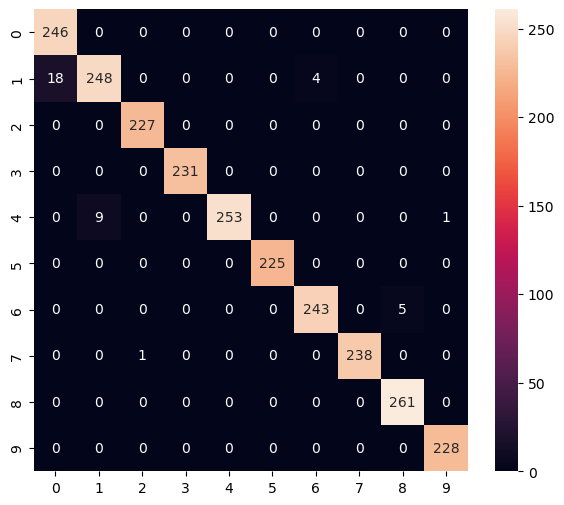

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       246
           1       0.96      0.92      0.94       270
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00       231
           4       1.00      0.96      0.98       263
           5       1.00      1.00      1.00       225
           6       0.98      0.98      0.98       248
           7       1.00      1.00      1.00       239
           8       0.98      1.00      0.99       261
           9       1.00      1.00      1.00       228

    accuracy                           0.98      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.98      0.98      0.98      2438



In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_test, y_pred):
    labels = sorted(list(set(y_test)))
    cmx_data = confusion_matrix(y_test, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_test)), 0)
    plt.show()

    print('Classification Report')
    print(classification_report(y_test, y_pred))

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)

In [12]:
model.save(model_path, include_optimizer=False)

/Users/yychan/anaconda3/envs/mediapipe/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tf_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpzztngbco/assets


INFO:tensorflow:Assets written to: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpzztngbco/assets
2024-05-31 16:54:18.046305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-31 16:54:18.046331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-31 16:54:18.046825: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpzztngbco
2024-05-31 16:54:18.048672: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-31 16:54:18.048689: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpzztngbco
2024-05-31 16:54:18.052767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-05-31 16:54:18.054252: I tensorflow/cc/saved_model/load

6808

In [14]:
interpreter = tf.lite.Interpreter(model_path=tf_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array([x_test[0]]))

%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

UsageError: Line magic function `%%time` not found.
